Authors: Salvatore Mandra (salvatore.mandra@nasa.gov)<br>

Copyright © 2023, United States Government, as represented by the Administrator
of the National Aeronautics and Space Administration. All rights reserved.

The *PySA*, a powerful tool for solving optimization problems is licensed under
the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

In [1]:
from more_itertools import divide
from multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time, sleep
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from scipy.linalg import circulant

from pysa.sa import Solver
from pysa.ising import get_energy

# Using 'float64' is about ~20% slower
float_type = 'float32'

c:\Users\tomto\scoop\apps\python\3.14.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Channel Generation Function ---
def create_sparse_dd_channel(M, N, n_paths, normalize=True, rng_seed=None):
    """
    Creates a sparse channel vector h for an M x N Delay-Doppler grid 
    with a specified number of non-zero paths.

    Args:
        M (int): Number of Delay (row) bins.
        N (int): Number of Doppler (column) bins.
        n_paths (int): The number of non-zero channel taps (paths).
        normalize (bool): If True, scales the channel so ||h||_2 = 1.
        rng_seed (int, optional): Seed for the random number generator for 
                                  reproducible results.

    Returns:
        np.array: The sparse complex channel vector h of size M*N.
    """
    
    total_bins = M * N
    if n_paths > total_bins:
        raise ValueError("Number of paths cannot exceed total number of bins (M * N).")

    # Set up random number generator
    rng = np.random.default_rng(rng_seed)

    # 1. Select the indices for the non-zero paths (DD bins)
    # This ensures the channel is sparse and the paths are located randomly.
    path_indices = rng.choice(total_bins, size=n_paths, replace=False)

    # 2. Generate complex gains for the chosen paths
    # Rayleigh fading is often modeled with IID complex Gaussian numbers.
    # We use a standard deviation of 1 for the complex components.
    path_gains_real = rng.normal(loc=0.0, scale=1.0, size=n_paths)
    path_gains_imag = rng.normal(loc=0.0, scale=1.0, size=n_paths)
    
    # Combine into complex gains
    path_gains = path_gains_real + 1j * path_gains_imag

    # 3. Assemble the full sparse channel vector
    h = np.zeros(total_bins, dtype=complex)
    h[path_indices] = path_gains

    # 4. Normalization (optional but good practice for simulation)
    if normalize:
        h = h / np.linalg.norm(h)
    
    return h


# --- True OTFS Sensing Matrix Function ---
def otfs_sensing_matrix(M, N):
    """
    Generates the true phi_OTFS matrix based on 2D convolution in the DD domain,
    calculated via 2D IFFT/FFT in the TF domain.

    Assumes a single-impulse pilot at the origin (0 delay, 0 Doppler).
    """
    L = M * N
    phi_OTFS = np.zeros((L, L), dtype=complex)

    k_indices, l_indices = np.arange(L), np.arange(L)
    m_out, n_out = np.divmod(k_indices, N)
    m_in, n_in = np.divmod(l_indices, N)
    
    for k in range(L):
        for l in range(L):
            m_l, n_l = m_in[l], n_in[l] 
            m_k, n_k = m_out[k], n_out[k]
            phi_OTFS[k, l] = np.exp(-1j * 2 * np.pi * (((m_l * m_k) / M) + ((n_l * n_k) / N)))
        
    return phi_OTFS


def otfs_mle_to_ising_bipolar_model(M, N, tx_pilot, rx_pilot, n_bits=2, amp_max=1.0, sparsity_lambda=0.0):
    """
    Converts OTFS Channel Estimation (MLE) to Ising Hamiltonian parameters
    using the Bipolar Additive Offset method to handle negative gains.
    """
    
    # 1. System Model Construction (y = Phi * h)
    N_total = M * N
    y = rx_pilot
    
    # Generate the TRUE SENSING MATRIX (Phi_OTFS)
    Phi_OTFS = otfs_sensing_matrix(M, N) 
    
    # 2. Real-Valued Decomposition
    # y_real remains the same
    y_real = np.concatenate([y.real, y.imag])
    
    # Phi_real remains the same structure
    Phi_real = np.block([
        [Phi_OTFS.real, -Phi_OTFS.imag],
        [Phi_OTFS.imag,  Phi_OTFS.real]
    ])
    
    # 3. Bipolar Binary Quantization Matrix (T_new)
    n_continuous_vars = 2 * N_total
    n_qubits = n_continuous_vars * n_bits

    # The weights must cover the doubled range: [0, 2 * amp_max]
    T_new = np.zeros((n_continuous_vars, n_qubits), dtype=float)
    # The weight factor is 2*amp_max * 2^-(j+1)
    weights_bipolar = np.array([2**(-i-1) for i in range(n_bits)]) * (2 * amp_max)
    
    for i in range(n_continuous_vars):
        for j in range(n_bits):
            T_new[i, i * n_bits + j] = weights_bipolar[j]

    # 4. Modify the Received Signal Vector (y_mod)
    # The offset vector 'b' has 2*MN elements, all equal to amp_max
    b_offset = amp_max * np.ones(n_continuous_vars)
    
    # We use y_mod = y_real + Phi_real @ b_offset
    y_mod = y_real + Phi_real @ b_offset

    # 5. Compute QUBO Matrices
    A_new = Phi_real @ T_new
    
    # Q_qubo = A_new.T @ A_new
    Q_qubo = np.dot(A_new.T, A_new) 
    
    # L_qubo = -2 * y_mod.T @ A_new
    L_qubo = -2 * np.dot(y_mod.T, A_new)
    
    # Add L0 sparsity penalty: L_qubo + lambda (This is an L1 penalty on x, but used as L0 approximation here)
    if sparsity_lambda > 0:
        L_qubo = L_qubo + sparsity_lambda

    # 6. Convert QUBO to Ising (x_i = (1 - s_i) / 2)
    h_ising = np.zeros(n_qubits)
    J_ising = np.zeros((n_qubits, n_qubits))
    
    # Compute J (Couplings): J_ij = Q_ij / 2.0 (for i != j)
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            J_val = Q_qubo[i, j] / 2.0 
            J_ising[i, j] = J_val
            J_ising[j, i] = J_val 

    # Compute h (Local Fields): h_i = -L_i/2 - sum_j Q_ij / 2.0
    for i in range(n_qubits):
        term_L = -L_qubo[i] / 2.0
        term_Q_total = -np.sum(Q_qubo[i, :]) / 2.0
        h_ising[i] = term_L + term_Q_total

    return h_ising, J_ising, amp_max # Return amp_max for demapping


if __name__ == "__main__":
    # Number of delay(M)-Doppler(N) bins
    M_dim = 4
    N_dim = 4
    L_total = M_dim * N_dim

    # Number of bits for gain quantization
    n_bits = 4

    # Number of paths
    num_paths = 3
    
    # 1. Generate Channel (h_true)
    h_true = create_sparse_dd_channel(M_dim, N_dim, num_paths, rng_seed=42)

    # 2. Generate Pilot (tx) and Received Signal (rx)
    tx = np.zeros((M_dim,N_dim), dtype=complex)
    tx[0,0] = 1.0 + 0j

    Phi_OTFS = otfs_sensing_matrix(M_dim, N_dim)

    rx = Phi_OTFS @ h_true + 0.1 * (np.random.randn(L_total) + 1j * np.random.randn(L_total))

    # Using n bits per real number, so we expect L_bins * 2(re/im) * n_bits = #(qubits)
    # 3. Convert to Ising
    h, J, amp_max_val = otfs_mle_to_ising_bipolar_model(
        M_dim, N_dim, 
        tx, rx, 
        n_bits=n_bits, 
        sparsity_lambda=0.5
    )

    # --- Verification ---
    print(f"Total non-zero paths requested: {num_paths}")
    print(f"Actual non-zero paths in h_true: {np.count_nonzero(h_true)}")
    print(f"Norm of h_true: {np.linalg.norm(h_true):.4f} (Should be ~1.0 if normalized)")
    print("\nh_true:")
    print(h_true)

    print(f"Ising formulation created.")
    print(f"Number of qubits (spins): {len(h)}")
    print(f"h vector shape: {h.shape}")
    print(f"J matrix shape: {J.shape}")
    
    # 3. Print a snippet of the J list format (i, j, value)
    print("\nSample Couplings (J):")
    count = 0
    for i in range(len(h)):
        for j in range(i+1, len(h)):
            if abs(J[i,j]) > 1e-6:
                print(f"Spin {i} <-> Spin {j}: {J[i,j]:.3f}")
                count += 1
            if count > 5: break
        if count > 5: break

Total non-zero paths requested: 3
Actual non-zero paths in h_true: 3
Norm of h_true: 1.0000 (Should be ~1.0 if normalized)

h_true:
[ 0.        +0.j         -0.76505263-0.12400711j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.36882036+0.05012961j -0.51061911-0.00658818j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j        ]
Ising formulation created.
Number of qubits (spins): 128
h vector shape: (128,)
J matrix shape: (128, 128)

Sample Couplings (J):
Spin 0 <-> Spin 1: 4.000
Spin 0 <-> Spin 2: 2.000
Spin 0 <-> Spin 3: 1.000
Spin 1 <-> Spin 2: 1.000
Spin 1 <-> Spin 3: 0.500
Spin 2 <-> Spin 3: 0.250


In [651]:
print(tx)
print(Phi_OTFS)
print(h_true)
print(rx.reshape(M_dim, N_dim))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j
   1.00000000e+00-0.00000000e+00j  1.00000000e+00-0.00000000e+00j]
 [ 1.00000000e+00-0.00000000e+00j  6.12323400e-17-1.00000000e+00j
  -1.00000000e+00-1.22464680e-16j -1.83697020e-16+1.00000000e+00j
   1.00000000e+00-0.00000000e+00j  6.12323400e-17-1.00000000e+00j
  -1.00000000e+00-1.22464680e-16j -1.83697020e-16+1.00000000e+00j
   1.00000000e+00-0.00000000e+00j  6.12323400e-17-1.00000000e+00j
  -1.00000000e+0

In [26]:
# Your data
# h: shape (n_vars,)
# J: shape (n_vars, n_vars), symmetric
n_vars = h.shape[0]

# Start from your coupling matrix
problem = J.astype(np.float32).copy()

# Add local fields to the diagonal
for i in range(n_vars):
    problem[i, i] += h[i]

float_type = "float32"
solver = Solver(problem=problem, problem_type="ising", float_type=float_type)

In [28]:
# Number of variables
n_sweeps = 100
n_replicas = 2
n_reads = 100
min_temp = 0.1
max_temp = 0.3

In [ ]:
# Generate random problem
problem = 2 * np.random.random((n_vars, n_vars)) - 1
problem = (problem + problem.T) / 2

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

In [29]:
# Apply Metropolis, same initialization
res_1 = solver.metropolis_update(
    num_sweeps=n_sweeps,
    num_reads=n_reads,
    num_replicas=n_replicas,
    update_strategy='sequential',
    min_temp=min_temp,
    max_temp=max_temp,
    initialize_strategy='ones',
    recompute_energy=True,
    sort_output_temps=True,
    parallel=True,  # True by default
    verbose=True)

100%|██████████| 100/100 [00:00<00:00, 844.18it/s]


In [1462]:
# Apply Metropolis, random initialization
res_1 = solver.metropolis_update(
    num_sweeps=n_sweeps,
    num_reads=n_reads,
    num_replicas=n_replicas,
    update_strategy='random',
    min_temp=min_temp,
    max_temp=max_temp,
    initialize_strategy='random',
    recompute_energy=True,
    sort_output_temps=True,
    parallel=True,  # True by default
    verbose=True)

100%|██████████| 100/100 [00:00<00:00, 813.06it/s]


Estimated P(reach global minimum) = 0.71
0    -200.802765
1    -200.802765
2    -200.802765
3    -200.802765
4    -200.802765
         ...    
95   -200.689133
96   -200.802765
97   -200.802765
98   -200.689133
99   -200.802765
Name: best_energy, Length: 100, dtype: float64
-200.80276489257812


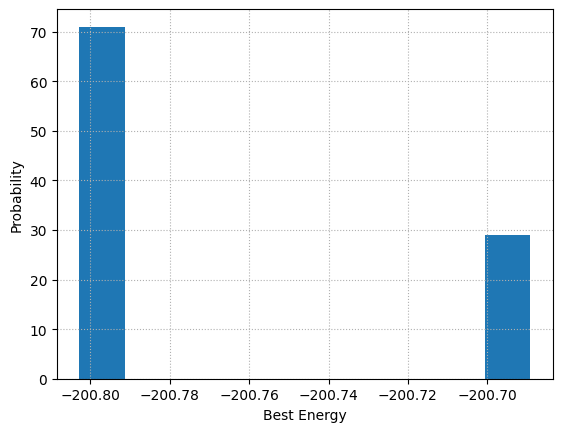

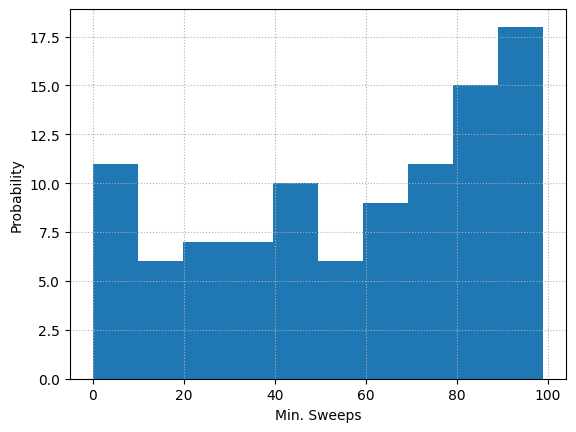

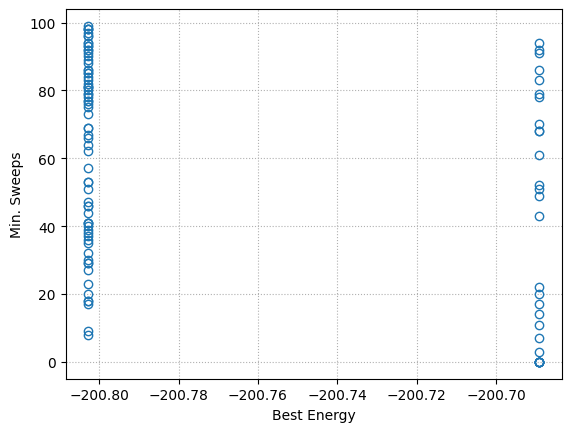

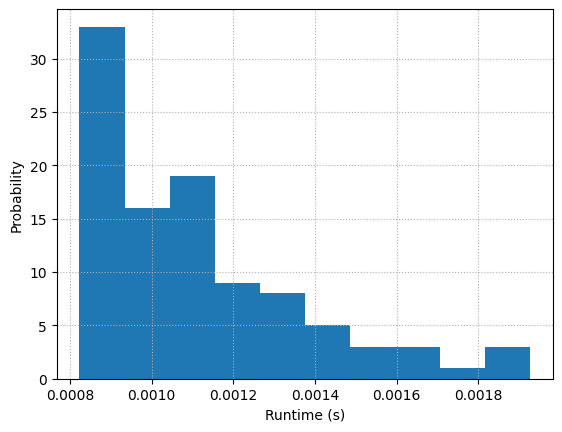

In [30]:
# Plots

# Collect all energies from all reads
all_energies = res_1['best_energy']

# Best energy observed (global minimum over these samples)
E_min = all_energies.min()
# E_min = -209.41104125976562

num_samples = all_energies.size
num_at_global_min = np.sum(np.isclose(all_energies, E_min, rtol=1e-8, atol=1e-6))

p_global_min = num_at_global_min / num_samples
print("Estimated P(reach global minimum) =", p_global_min)

print(all_energies)
print(E_min)
plt.hist(res_1['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_1['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_1[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

plt.hist(res_1['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

In [ ]:
# Demap best state configuration for estimated channel path gains and equalize the received signal

def demap_spin_to_channel_bipolar(s_best, M, N, n_bits, amp_max):
    """
    Decodes the optimal spin configuration (s_best) from the Ising solver 
    into the estimated complex Delay-Doppler Channel Matrix (H_DD_est) 
    using the Bipolar Additive Offset demapping.
    """
    
    L = M * N
    N_continuous_vars = 2 * L
    
    # 1. Spin to Binary Variable (s_best -> x_best)
    x_best = (1 - s_best) / 2
    
    # 2. Binary to Continuous Variable (x_best -> h_shifted_est)
    # The new weights_bipolar must be used, corresponding to a range of 2*amp_max
    weights_bipolar = np.array([2**(-i-1) for i in range(n_bits)]) * (2 * amp_max)
    
    h_shifted_est = np.zeros(N_continuous_vars, dtype=float)
    
    for i in range(N_continuous_vars):
        start_idx = i * n_bits
        end_idx = start_idx + n_bits
        binary_segment = x_best[start_idx:end_idx]
        
        # h_shifted_est is the UNIPOLAR estimation
        h_shifted_est[i] = np.dot(binary_segment, weights_bipolar)
    
    # 3. Apply the Bipolar Offset: h_real = h_shifted - amp_max
    h_real_est = h_shifted_est - amp_max
    
    # 4. Continuous to Complex Matrix (h_real_est -> H_DD_est)
    # Separate the real and imaginary parts
    h_real = h_real_est[:L]
    h_imag = h_real_est[L:]
    
    # Combine to form the complex channel tap vector
    h_est_vector = h_real + 1j * h_imag
    
    # Reshape the vector into the final M x N Delay-Doppler channel matrix
    H_DD_est = h_est_vector.reshape((M, N))
    
    return H_DD_est

In [15]:
print(res_1['best_state'][99])

[-1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
  1.  1.]


In [ ]:
# --- Example of Usage Demonstration ---

# Define Grid and Parameters (Using a small, testable grid)
M = 4
N = 4
n_bits = 4      # 2 bits per Re/Im component
amp_max = 1.0   # Max channel gain is 1.0 (for normalization)

s_best_simulated = res_1['best_state'][99]

# Run the Demapping function
H_est = demap_spin_to_channel_bipolar(
    s_best_simulated, M, N, n_bits, amp_max 
)

print(f"--- Final Estimated Channel Matrix (H_DD_est) ---")
print(H_est)
print(h_true.reshape(M,N))

--- Final Estimated Channel Matrix (H_DD_est) ---
[[ 0.  +0.j -0.75+0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.25+0.j -0.5 +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]]
[[ 0.        +0.j         -0.76505263-0.12400711j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.36882036+0.05012961j
  -0.51061911-0.00658818j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]


In [33]:
# Compare estimated channel with true channel (NMSE)

def compare_channel_matrices(H_true, H_est):
    """
    Compares the estimated complex channel matrix (H_est) against the 
    true complex channel matrix (H_true) using two metrics:
    1. Mean Squared Error (MSE)
    2. Normalized Mean Squared Error (NMSE) in dB

    Args:
        H_true (np.array): The true M x N complex channel matrix.
        H_est (np.array): The estimated M x N complex channel matrix.

    Returns:
        dict: A dictionary containing 'MSE' and 'NMSE_dB'.
    """
    # 1. Vectorize the matrices to calculate the Frobenius (L2) norm
    h_true_vector = H_true.flatten()
    h_est_vector = H_est.flatten()

    # 2. Calculate the Error Vector
    error_vector = h_true_vector - h_est_vector

    # 3. Calculate the Sum of Squared Error (Numerator of NMSE)
    # ||h_true - h_est||_2^2
    squared_error_norm = np.sum(np.abs(error_vector)**2)

    # 4. Calculate the Energy of the True Channel (Denominator of NMSE)
    # ||h_true||_2^2
    true_channel_norm = np.sum(np.abs(h_true_vector)**2)

    # 5. Calculate MSE
    # MSE = Sum of Squared Error / Total Number of Taps
    mse = squared_error_norm / h_true_vector.size

    # 6. Calculate NMSE (in dB)
    if true_channel_norm == 0:
        # Handle the edge case where the true channel is all zeros (shouldn't happen in OTFS)
        nmse_db = np.nan
    else:
        nmse = squared_error_norm / true_channel_norm
        nmse_db = 10 * np.log10(nmse)
    
    return {
        "MSE": mse,
        "NMSE_dB": nmse_db
    }

# --- Example Usage (Assuming a successful demapping result) ---

# Run Comparisons
metrics = compare_channel_matrices(h_true.reshape(M,N), H_est)

print("--- Comparison Metrics ---")
print(f"Estimate NMSE: {metrics['NMSE_dB']:.4f} dB")
print(f"Estimate MSE:    {metrics['MSE']:.6f}")

--- Comparison Metrics ---
Estimate NMSE: -14.8957 dB
Estimate MSE:    0.002024


In [35]:
# Sweep Analysis
sweep_values = np.unique(np.round(np.logspace(0, 3, 20))).astype(int)  # 1..1000, ~20 points
probs = []
runtimes = []

for n_sweeps in sweep_values:
    res = solver.metropolis_update(
        num_sweeps=n_sweeps,
        num_reads=50*n_reads,
        num_replicas=n_replicas,
        update_strategy='sequential',
        min_temp=min_temp,
        max_temp=max_temp,
        initialize_strategy='ones',
        recompute_energy=True,
        sort_output_temps=True,
        parallel=True,
        verbose=False,
    )

    avg_runtime = sum(res['runtime (us)']) / len(res['runtime (us)'])

    # Collect all energies from all reads
    all_energies = res['best_energy']

    # Best energy observed (global minimum over these samples)
    E_min = -200.80276489257812

    num_samples = all_energies.size
    num_at_global_min = np.sum(np.isclose(all_energies, E_min, rtol=1e-6, atol=1e-4))

    p_global_min = num_at_global_min / num_samples

    probs.append(p_global_min)
    runtimes.append(avg_runtime / 1e6)

# Set values for plot
sweep_values = np.array(sweep_values)
probs = np.array(probs)
runtimes = np.array(runtimes)

C:\Users\tomto\AppData\Local\Temp\ipykernel_23336\2772765224.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim(0,1)


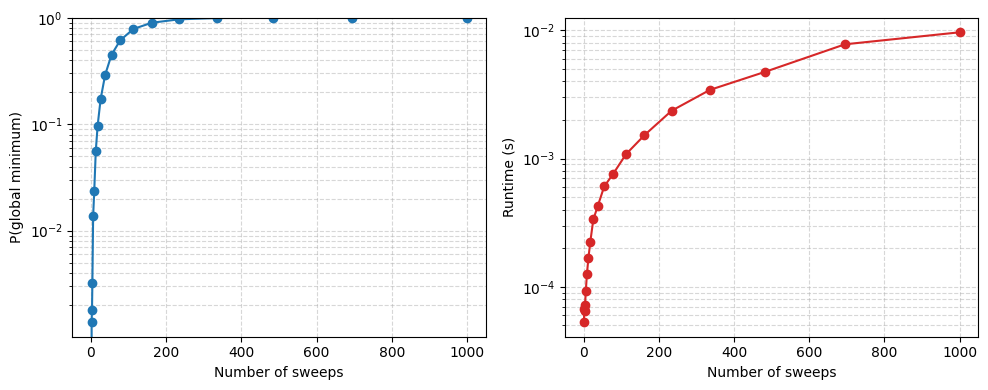

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Probability vs sweeps (log10 y)
ax[0].plot(sweep_values, probs, marker='o')
ax[0].set_xscale('linear')
ax[0].set_yscale('log', base=10)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('Number of sweeps')
ax[0].set_ylabel('P(global minimum)')
ax[0].grid(True, which='both', ls='--', alpha=0.5)

# Runtime vs sweeps (log10 y)
ax[1].plot(sweep_values, runtimes, marker='o', color='tab:red')
ax[1].set_xscale('linear')
ax[1].set_yscale('log', base=10)
ax[1].set_xlabel('Number of sweeps')
ax[1].set_ylabel('Runtime (s)')
ax[1].grid(True, which='both', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

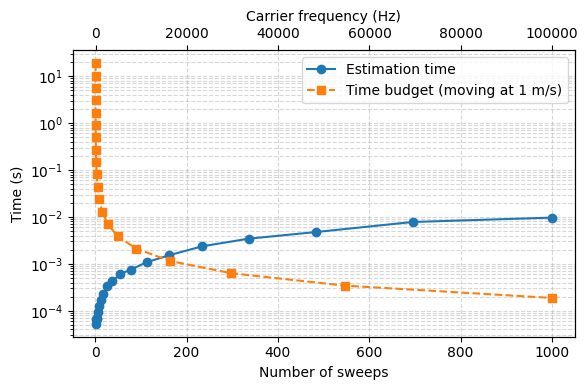

In [37]:
# Compare Simulation Runtime with Channel Estimation Time Budget (5% of Coherence Time)

estimationTimeBudget = []

# Set Carrier Frequency from 1Hz to 100KHz
carrierFrequencies = np.logspace(0,5,20)

for fc in carrierFrequencies:
    ds = 2 * (fc * 1 / 1500)  # Calculate Doppler Spread
    tc = 1 / (2 * ds)           # Calculate Coherence Time
    estimationTimeBudget.append(tc * 0.05)

fig, ax_sweeps = plt.subplots(figsize=(6, 4))

# --- Bottom: sweeps vs probability (log10 y) ---
ax_sweeps.plot(sweep_values, runtimes, 'o-', color='tab:blue', label='Estimation time')
ax_sweeps.set_xlabel('Number of sweeps')
ax_sweeps.set_ylabel('Time (s)')
ax_sweeps.set_yscale('log', base=10)
ax_sweeps.grid(True, which='both', ls='--', alpha=0.5)

# --- Top: carrierFrequency vs estimationTimeBudget, overlaid ---
# Create a new axes on top, sharing the *y* axis but with its own x
ax_freq = ax_sweeps.twiny()

# Plot in terms of frequency on this axes
ax_freq.plot(carrierFrequencies, estimationTimeBudget, 's--', color='tab:orange',
             label='Time budget (moving at 1 m/s)')

# Put the x-label on the top
ax_freq.set_xlabel('Carrier frequency (Hz)')

# Make sure both axes cover the same y-range (log) so they overlap nicely
ax_freq.set_ylim(ax_sweeps.get_ylim())
ax_freq.set_yscale('log', base=10)

# Optional: adjust x-lims of each axis independently
# ax_sweeps.set_xlim(sweep_values.min(), sweep_values.max())
# ax_freq.set_xlim(carrierFrequencies.min(), carrierFrequencies.max())

# Combined legend
lines1, labels1 = ax_sweeps.get_legend_handles_labels()
lines2, labels2 = ax_freq.get_legend_handles_labels()
ax_sweeps.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()

In [1429]:
# Temperature Phase Diagram

min_vals = np.arange(0.05, 0.15, 0.01)
max_vals = np.arange(0.1, 0.5, 0.02)

results = []

for min_temp in min_vals:
    for max_temp in max_vals:
        # Skip unphysical cases if you want min_temp <= max_temp
        if min_temp > max_temp:
            prob_best = 0
        else:
            res = solver.metropolis_update(
                num_sweeps=n_sweeps,
                num_reads=n_reads,
                num_replicas=n_replicas,
                update_strategy='sequential',
                min_temp=min_temp,
                max_temp=max_temp,
                initialize_strategy='ones',
                recompute_energy=True,
                sort_output_temps=True,
                parallel=True,
                verbose=False,
            )

            # Collect all energies from this run
            all_energies = res['best_energy']
            best_energy = all_energies.min()
            best_energy = -209.41104125976562
            print(best_energy)

            # Optionally: empirical probability of best energy within this run
            count_best = np.sum(np.isclose(all_energies, best_energy, rtol=1e-4, atol=1e-2))
            prob_best = count_best / all_energies.size
            print(prob_best)

        results.append(
            dict(
                min_temp=min_temp,
                max_temp=max_temp,
                prob_best=prob_best
            )
        )

sweep_df = pd.DataFrame(results)
# display(sweep_df)

# Build a grid of (min_temp, max_temp)
x_vals = np.sort(sweep_df['min_temp'].unique())
y_vals = np.sort(sweep_df['max_temp'].unique())
X, Y = np.meshgrid(x_vals, y_vals)

# Fill Z with prob_best values
Z = np.empty_like(X, dtype=float)
for i, ymin in enumerate(y_vals):
    for j, xmin in enumerate(x_vals):
        mask = (sweep_df['min_temp'] == xmin) & (sweep_df['max_temp'] == ymin)
        Z[i, j] = sweep_df.loc[mask, 'prob_best'].iloc[0] if mask.any() else np.nan

-209.41104125976562
0.0
-209.41104125976562
0.03
-209.41104125976562
0.15
-209.41104125976562
0.23
-209.41104125976562
0.45
-209.41104125976562
0.54
-209.41104125976562
0.75
-209.41104125976562
0.85
-209.41104125976562
0.9
-209.41104125976562
0.95
-209.41104125976562
0.95
-209.41104125976562
0.93
-209.41104125976562
0.84
-209.41104125976562
0.77
-209.41104125976562
0.78
-209.41104125976562
0.49
-209.41104125976562
0.38
-209.41104125976562
0.23
-209.41104125976562
0.15
-209.41104125976562
0.06
-209.41104125976562
0.01
-209.41104125976562
0.01
-209.41104125976562
0.08
-209.41104125976562
0.26
-209.41104125976562
0.38
-209.41104125976562
0.61
-209.41104125976562
0.74
-209.41104125976562
0.89
-209.41104125976562
0.92
-209.41104125976562
0.94
-209.41104125976562
0.94
-209.41104125976562
0.98
-209.41104125976562
0.91
-209.41104125976562
0.79
-209.41104125976562
0.72
-209.41104125976562
0.55
-209.41104125976562
0.5
-209.41104125976562
0.25
-209.41104125976562
0.17
-209.41104125976562
0.11
-20

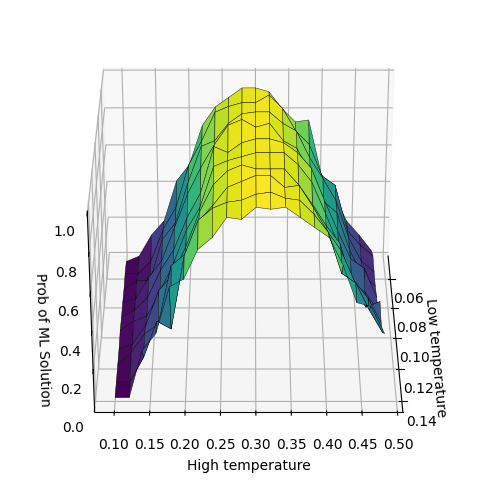

In [1431]:
# Plot 3D phase diagram
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3)

ax.set_xlabel('Low temperature')
ax.set_ylabel('High temperature')
ax.set_zlabel('Prob of ML Solution')

ax.view_init(azim=0, elev=30)

plt.show()

In [1066]:
# Check that all the energies match
assert (np.all([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

100%|██████████| 100/100 [00:00<00:00, 857.89it/s]


In [132]:
# Temperatures, initial states and initial energies can be provided
res_1b = solver.metropolis_update(num_sweeps=n_sweeps,
                                  num_reads=n_reads,
                                  update_strategy='sequential',
                                  temps=res_1.loc[0].temps,
                                  initialize_strategy=res_1.loc[0].states,
                                  init_energies=res_1.loc[0].energies,
                                  recompute_energy=False,
                                  sort_output_temps=True,
                                  verbose=True)

100%|██████████| 100/100 [00:00<00:00, 236.63it/s]


In [ ]:
# Check that all the energies match
assert (np.all([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1b[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

100%|██████████| 100/100 [00:00<00:00, 2884.88it/s]


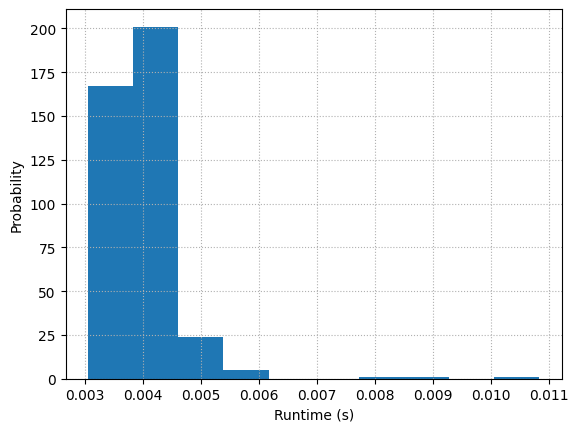

In [12]:
# plt.hist(res_1['best_energy'])
# plt.grid(ls=':')
# plt.xlabel('Best Energy')
# plt.ylabel('Probability')
# plt.show()

plt.hist(res_1['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

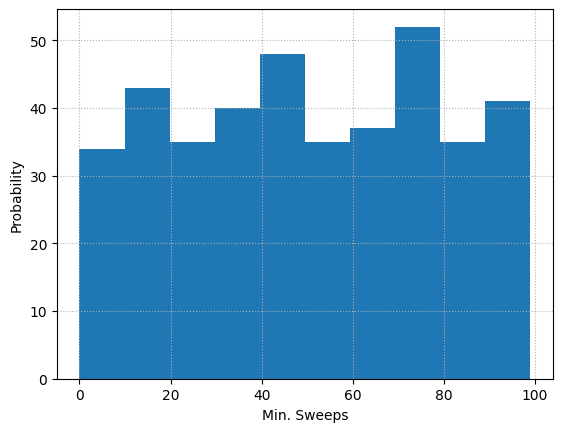

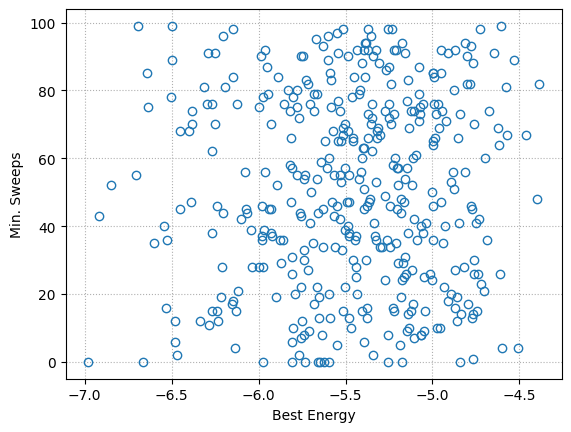

In [13]:
plt.hist(res_1['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_1[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [14]:
# Job can be sent to background 
_handle = solver.metropolis_update(num_sweeps=10 * n_sweeps,
                                   num_reads=n_reads,
                                   num_replicas=n_replicas,
                                   update_strategy='random',
                                   min_temp=min_temp,
                                   max_temp=max_temp,
                                   initialize_strategy='random',
                                   recompute_energy=False,
                                   sort_output_temps=False,
                                   send_background=True,
                                   verbose=True)

  0%|          | 0/400 [00:00<?, ?it/s]

  6%|▌         | 23/400 [00:02<00:23, 16.38it/s]

In [15]:
# It should say that the results are not ready
print(f'Results ready? {_handle.done()}')
res_2 = _handle.result() # This call blocks till the results are ready
print(f'Results ready? {_handle.done()}')

  7%|▋         | 28/400 [00:03<00:21, 17.47it/s]

Results ready? False


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]

Results ready? True


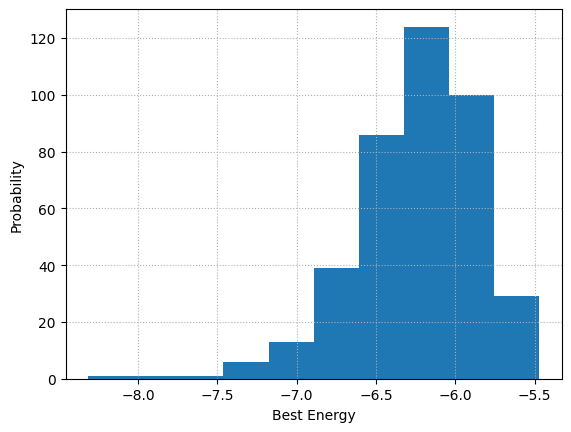

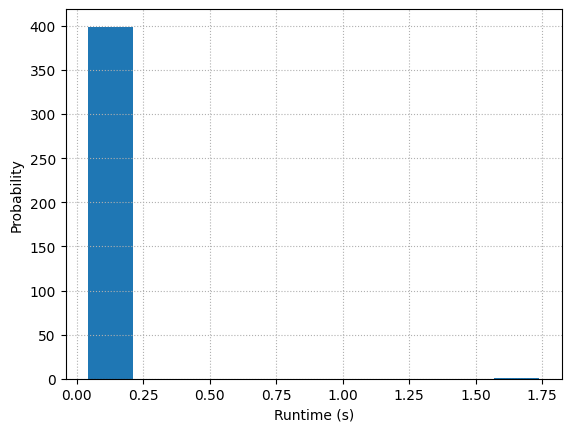

In [18]:
plt.hist(res_2['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_2['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

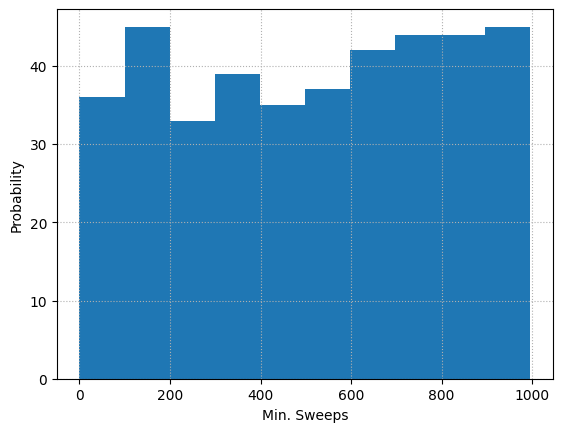

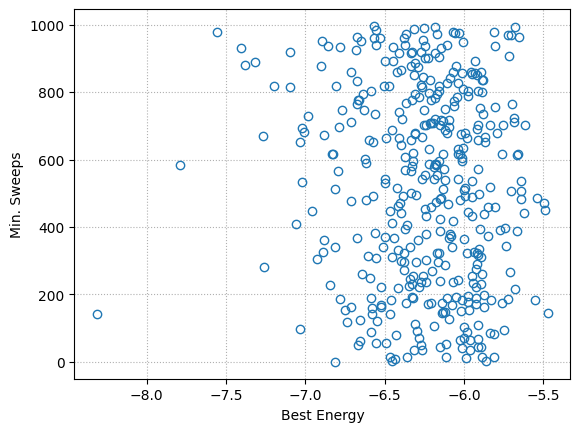

In [19]:
plt.hist(res_2['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_2[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [963]:
# Round-off error can accumulate (if recompute_energy=False)
print(f'Best energy (# sweeps =  {n_sweeps}): {np.min(res_1["best_energy"])}')
print(
    f'Best energy (# sweeps = {10*n_sweeps}): {np.min(res_2["best_energy"])}')

Best energy (# sweeps =  100): -27.08122500765603
Best energy (# sweeps = 1000): -27.096122642658884


In [964]:
# Let's recompute the energy given the best state
print(
    f'Best energy (# sweeps =  {n_sweeps}):',
    solver.get_energy(res_1.best_state[np.argmin(res_1.best_energy)])
)
print(
    f'Best energy (# sweeps = {10*n_sweeps}):',
    solver.get_energy(res_2.best_state[np.argmin(res_2.best_energy)])
)

Best energy (# sweeps =  100): -27.081226348876953
Best energy (# sweeps = 1000): -27.09612464904785


-----

In [19]:
# Number of variables
n_vars = 32 * 32 * 3
n_replicas = 100

# # Generate random problem
# problem = 2 * np.random.random((n_vars, n_vars)) - 1
# problem = (problem + problem.T) / 2

# Your data: h and J
# h: shape (n_vars), J: shape (n_vars, n_vars)
n_vars = len(h)

problem = np.zeros((n_vars, n_vars), dtype=np.float32)

# Add couplings (symmetric)
for i in range(n_vars):
    for j in range(n_vars):
        problem[i,j] += J[i,j]
problem = (problem + problem.T) / 2

# Add local fields on the diagonal
for i in range(n_vars):
    problem[i,i] += h[i]

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

In [410]:
# Let's define some initial random configurations ...
confs = 2 * np.random.randint(2, size=(n_replicas, n_vars)) - 1

# ... and get the corresponding energies
energies = [solver.get_energy(x) for x in confs]

In [411]:
# Run once to compile
solver.metropolis_update(num_sweeps=1,
                         num_reads=1,
                         update_strategy='sequential',
                         temps=[1] * n_replicas,
                         initialize_strategy=confs,
                         init_energies=energies,
                         recompute_energy=False,
                         sort_output_temps=False,
                         return_dataframe=False,
                         parallel=True,
                         use_pt=False,
                         verbose=False);

In [412]:
%%timeit -n 5 -r 5
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

261 μs ± 60 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

# Update configurations and energies
confs = _res[0]['states']
energies = _res[0]['energies']

# Let's check that energies are computed correctly
assert (np.all([
    np.isclose(solver.get_energy(c), e, atol=1e-6)
    for c, e in tqdm(zip(confs, energies), total=len(confs))
]))

100%|██████████| 2/2 [00:00<00:00, 1382.21it/s]
